Source: https://github.com/ajwdewit/pcse_notebooks/blob/master/08a%20Data%20assimilation%20with%20the%20EnKF.ipynb

In [108]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [109]:
variables_for_DA = ["LAI", "SM"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]

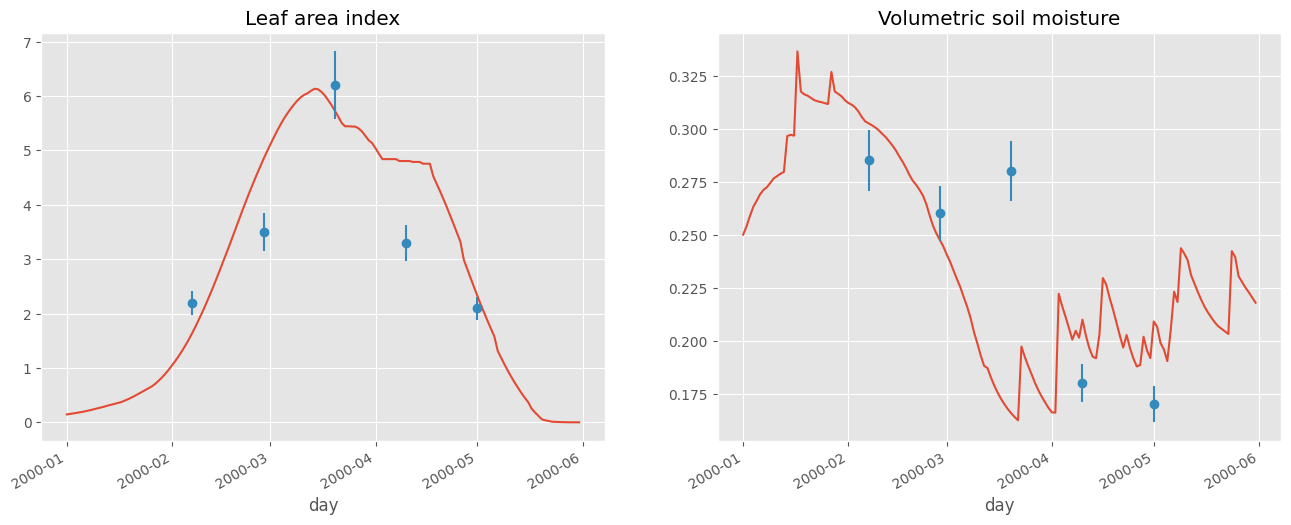

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df["LAI"].plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df["SM"].plot(ax=axes[1], label="rootzone soil moisture")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

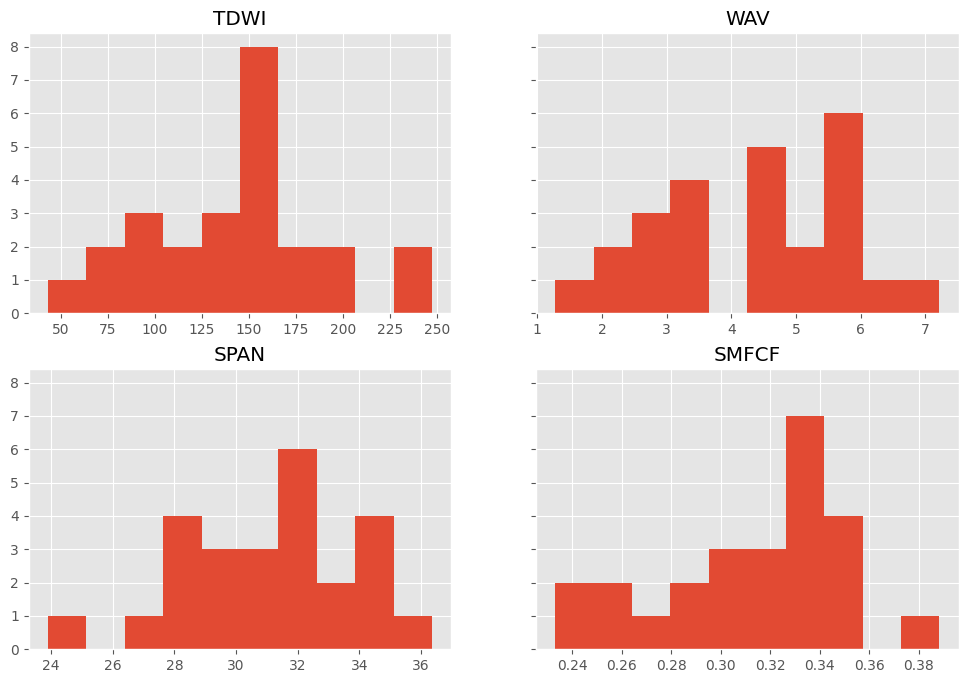

In [111]:
ensemble_size = 25
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

In [112]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

In [113]:
show_output = True

day, obs = observations_for_DA.pop(0)
for member in ensemble:
    member.run_till(day)
print("Ensemble now at day %s" % member.day)
print("%s observations left!" % len(observations_for_DA))

Ensemble now at day 2000-02-07
4 observations left!


In [114]:
collected_states = []
for member in ensemble:
    t = {}
    for state in variables_for_DA:
        t[state] = member.get_variable(state)
    collected_states.append(t)
df_A = pd.DataFrame(collected_states)
A = np.matrix(df_A).T

# Show first 5 rows if output
df_A.head(5) if show_output else None

,LAI,SM
0,0.910758,0.250896
1,1.381313,0.209188
2,1.242942,0.259991
3,1.423062,0.257028
4,1.020182,0.247293


In [115]:
P_e = np.matrix(df_A.cov())
df_A.cov() if show_output else None

,LAI,SM
LAI,0.092670,-0.002657
SM,-0.002657,0.000618


In [116]:
perturbed_obs = []
for state in variables_for_DA:
    (value, std) = obs[state]
    d = np.random.normal(value, std, (ensemble_size))
    perturbed_obs.append(d)
df_perturbed_obs = pd.DataFrame(perturbed_obs).T
df_perturbed_obs.columns = variables_for_DA
D = np.matrix(df_perturbed_obs).T
R_e = np.matrix(df_perturbed_obs.cov())

# Show first 5 rows of perturbed observations if output
df_perturbed_obs.head(5) if show_output else None

,LAI,SM
0,2.215277,0.264382
1,2.309577,0.280196
2,2.089137,0.255782
3,2.030366,0.248823
4,2.506343,0.282842


In [117]:
# Here we compute the Kalman gain
H = np.identity(len(obs))
K1 = P_e * (H.T)
K2 = (H * P_e) * H.T
K = K1 * ((K2 + R_e).I)
K if show_output else None

matrix([[ 0.71053631, -1.27264369],
        [-0.00980086,  0.6649106 ]])

In [118]:
# Here we compute the analysed states
Aa = A + K * (D - (H * A))
df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
df_Aa.head(5) if show_output else None

,LAI,SM
0,1.820503,0.247078
1,1.950511,0.247304
2,1.849551,0.248899
3,1.865016,0.245621
4,2.030912,0.256364


In [119]:
for member, new_states in zip(ensemble, df_Aa.itertuples()):
    r1 = member.set_variable("LAI", new_states.LAI)
    r2 = member.set_variable("SM", new_states.SM)

In [120]:
for member in ensemble:
    member.run_till_terminate()

In [121]:
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]

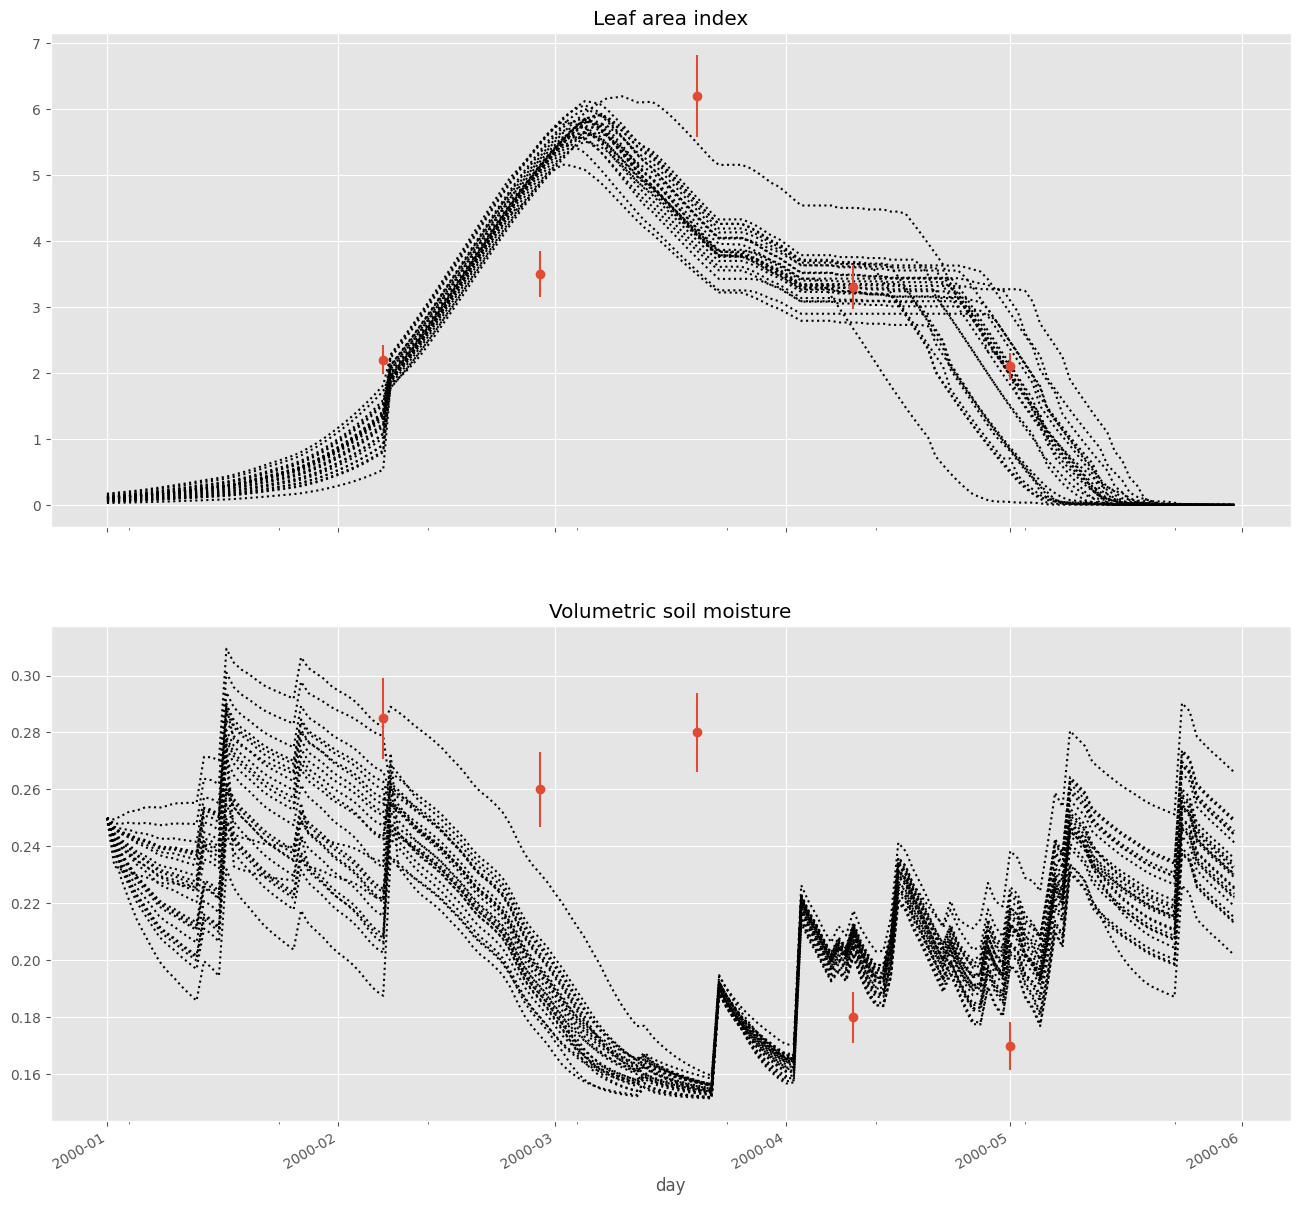

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["SM"].plot(style="k:", ax=axes[1])
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()